<font size="+3"><strong>Google Stock Volatility Forecasting</strong></font>

In [73]:
# Install libraries and their dependencies
#!pip install arch
#!pip install pydantic
#pip install pydantic[dotenv]
#pip install fastapi
#!pip install pydantic_settings

In [1]:
%load_ext autoreload
%autoreload 2
from arch.univariate.base import ARCHModelResult

In [2]:
# Import libraries here
import pandas as pd
import sqlite3
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import requests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# import libraries we created
from data import SQLRepository, AlphaVantageAPI
from model import GarchModel
from config import settings

In [3]:
# get url for requests manually without our predefined AlphavantageAPI module
ticker = 'GOOGL'
output_size = 'full'
data_type = 'json'

url = (
    "https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?"
    "function=TIME_SERIES_DAILY&"
    f"symbol={ticker}&"
    f"outputsize={output_size}&"
    f"datatype={data_type}&"
    f"apikey={settings.alpha_api_key}"
      )

print("url type:", type(url))
url[:170]

url type: <class 'str'>


'https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?function=TIME_SERIES_DAILY&symbol=GOOGL&outputsize=full&datatype=json&apikey=0060eabd6569c8a0590bd77bb3f9634'

In [4]:
# get response from requests
response = requests.get(url=url)

print("response type:", type(response))

response type: <class 'requests.models.Response'>


In [5]:
# get response status code
response_code = response.status_code

print("code type:", type(response_code))
response_code

code type: <class 'int'>


200

In [6]:
# read response dict into dataframe without module
df_google = pd.DataFrame.from_dict(
    response.json()['Time Series (Daily)'],
    orient= 'index',
    dtype= 'float'
)

df_google.index = pd.DatetimeIndex(df_google.index)
df_google.index.name = 'date'

df_google.columns = [c.split('. ')[1] for c in df_google.columns]

print("df_google type:", type(df_google))
df_google.head()

df_google type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,volume
date,,,,,
2023-07-28,130.78,133.740,130.57,132.58,36591158.0
2023-07-27,131.67,133.240,128.79,129.40,44952074.0
2023-07-26,130.07,130.980,128.32,129.27,61682093.0
2023-07-25,121.36,123.145,121.02,122.21,52509551.0
2023-07-24,121.66,123.000,120.98,121.53,29723667.0


In [7]:
# using our Alphavantage module
# Instantiate model
api = AlphaVantageAPI()
df_google = api.get_daily(ticker=ticker)
df_google.head()

,open,high,low,close,volume
date,,,,,
2023-07-28,130.78,133.740,130.57,132.58,36591158.0
2023-07-27,131.67,133.240,128.79,129.40,44952074.0
2023-07-26,130.07,130.980,128.32,129.27,61682093.0
2023-07-25,121.36,123.145,121.02,122.21,52509551.0
2023-07-24,121.66,123.000,120.98,121.53,29723667.0


In [8]:
# connect to sql database
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
connection

In [9]:
# Insert `GOOGL` data into database using OUR MODULE
# Instantiate repo
repo = SQLRepository(connection=connection)

response = repo.insert_table(table_name=ticker, records=df_google, if_exists='replace')

In [10]:
# read data from database
df_google_read = repo.read_table(table_name=ticker, limit=3000)

print("df_google_read type:", type(df_google_read))
print("df_google_read shape:", df_google_read.shape)
df_google_read.head()

df_google_read type: <class 'pandas.core.frame.DataFrame'>
df_google_read shape: (3000, 5)


,open,high,low,close,volume
date,,,,,
2023-07-28,130.78,133.740,130.57,132.58,36591158.0
2023-07-27,131.67,133.240,128.79,129.40,44952074.0
2023-07-26,130.07,130.980,128.32,129.27,61682093.0
2023-07-25,121.36,123.145,121.02,122.21,52509551.0
2023-07-24,121.66,123.000,120.98,121.53,29723667.0


In [11]:
# create a daily returns column
df_google_read.sort_index(ascending=True, inplace=True)
df_google_read['return'] = df_google_read['close'].pct_change() * 100
y_google = df_google_read['return'].dropna()

print("y_google type:", type(y_google))
print("y_google shape:", y_google.shape)
y_google.head()

y_google type: <class 'pandas.core.series.Series'>
y_google shape: (2999,)


date
2011-08-26    1.311438
2011-08-29    2.319402
2011-08-30    0.300512
2011-08-31    0.048086
2011-09-01   -1.563886
Name: return, dtype: float64

In [12]:
google_daily_volatility = y_google.std()

print("google_daily_volatility type:", type(google_daily_volatility))
print("Google Daily Volatility:", google_daily_volatility)

google_daily_volatility type: <class 'float'>
Google Daily Volatility: 2.597982826577894


In [13]:
google_annual_volatility = google_daily_volatility * np.sqrt(252)

print("google_annual_volatility type:", type(google_annual_volatility))
print("Google Annual Volatility:", google_annual_volatility)

google_annual_volatility type: <class 'numpy.float64'>
Google Annual Volatility: 41.24169881725053


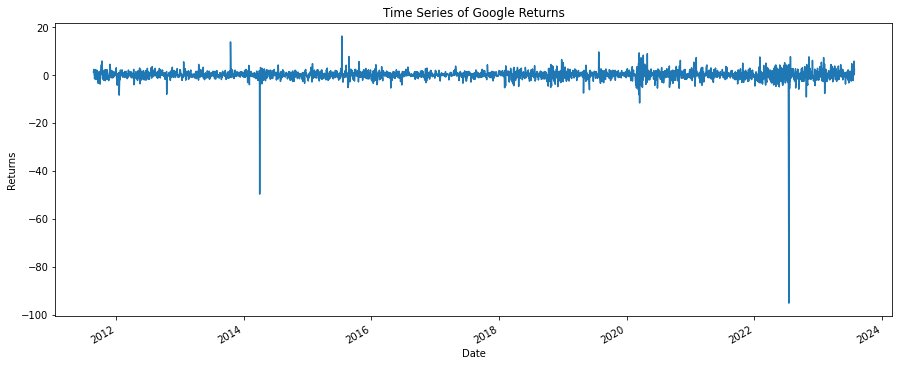

In [14]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_google` on `ax`
y_google.plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Returns")

# Add title
plt.title("Time Series of Google Returns");

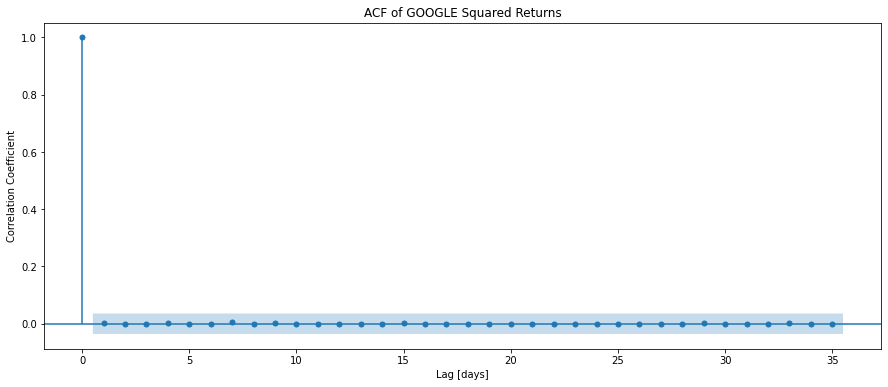

In [15]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_google**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")


# Add title
plt.title("ACF of GOOGLE Squared Returns");

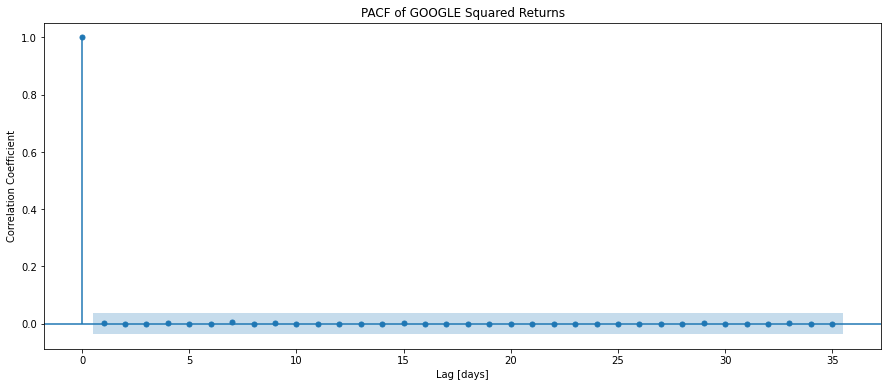

In [16]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))


# Create PACF of squared returns
plot_pacf(y_google**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")


# Add title
plt.title("PACF of GOOGLE Squared Returns");

In [17]:
# seperate training data
cutoff_test = int(len(y_google) * 0.8)
y_google_train = y_google.iloc[:cutoff_test]

print("y_google_train type:", type(y_google_train))
print("y_google_train shape:", y_google_train.shape)
y_google_train.head()

y_google_train type: <class 'pandas.core.series.Series'>
y_google_train shape: (2399,)


date
2011-08-26    1.311438
2011-08-29    2.319402
2011-08-30    0.300512
2011-08-31    0.048086
2011-09-01   -1.563886
Name: return, dtype: float64

In [18]:
# Build and train model
model = arch_model(
    y_google_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4888.09
Distribution:                  Normal   AIC:                           9784.17
Method:            Maximum Likelihood   BIC:                           9807.31
                                        No. Observations:                 2399
Date:                Sat, Jul 29 2023   Df Residuals:                     2398
Time:                        11:48:30   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1115  4.078e-02      2.735  6.242e-03 [3.159e-02,  0.191]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5398      0.366      1.473      0.141    [ -0.178,  1.258]
alpha[1]       0.1360  8.431e-02      1.613      0.107 [-2.925e-02,  0.301]
beta[1]        0.7591  3.632e-02     20.903  4.989e-97    [  0.688,  0.830]
===========================================================================

Covariance estimator: robust
"""

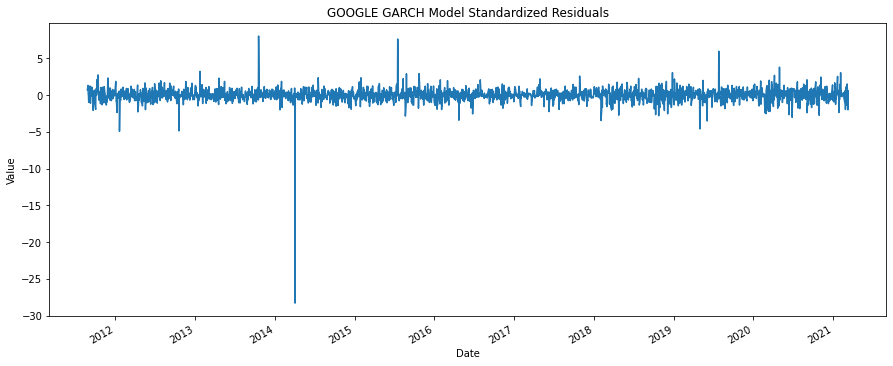

In [19]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Value")


# Add title
plt.title("GOOGLE GARCH Model Standardized Residuals");

In [20]:
# Import `build_model` function
from main import build_model

# Build model using new `MTNOY` data
model = build_model(ticker="GOOGL", use_new_data=True)

# Wrangle `GOOGL` returns
model.wrangle_data(n_observations=400)

# Fit GARCH(1,1) model to data
model.fit(p=1, q=1)

# Does model have AIC and BIC attributes?
assert hasattr(model, "aic")
assert hasattr(model, "bic")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1902.9060299349435
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1232.5510782703982
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1234.73066864861
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1232.5071753033214
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1232.4739088626266
Iteration:      6,   Func. Count:     34,   Neg. LLF: 1232.2616129870264
Iteration:      7,   Func. Count:     39,   Neg. LLF: 2417.7593059548785
Iteration:      8,   Func. Count:     45,   Neg. LLF: 1841.2921992962767
Iteration:      9,   Func. Count:     52,   Neg. LLF: 1232.0771321480725
Iteration:     10,   Func. Count:     58,   Neg. LLF: 1231.7276990874705
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1261.5920390672286
Iteration:     12,   Func. Count:     69,   Neg. LLF: 1395.7511266940344
Iteration:     13,   Func. Count:     75,   Neg. LLF: 1230.0484473999177
Iteration:     14,   Func. Count:     80,   Neg. LLF:

In [21]:
# Import `FitIn` class and `fit_model` function
from main import FitIn, fit_model

# Instantiate `FitIn` object
request = FitIn(ticker="GOOGL", use_new_data=False, n_observations=2500, p=1, q=1)

# Build model and fit to data, following parameters in `request`
fit_out = fit_model(request=request)

# Inspect `fit_out`
fit_out

Iteration:      1,   Func. Count:      6,   Neg. LLF: 16420.657097939515
Iteration:      2,   Func. Count:     18,   Neg. LLF: 12151.510302686886
Iteration:      3,   Func. Count:     26,   Neg. LLF: 8420.453644030153
Iteration:      4,   Func. Count:     33,   Neg. LLF: 5950.292193027956
Iteration:      5,   Func. Count:     38,   Neg. LLF: 5927.538399254301
Iteration:      6,   Func. Count:     43,   Neg. LLF: 5926.433710541662
Iteration:      7,   Func. Count:     48,   Neg. LLF: 5926.153350446515
Iteration:      8,   Func. Count:     53,   Neg. LLF: 5926.052632736682
Iteration:      9,   Func. Count:     58,   Neg. LLF: 5926.059448767553
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2994069.007978852
Iteration:     11,   Func. Count:     72,   Neg. LLF: 5938.305237327296
Iteration:     12,   Func. Count:     80,   Neg. LLF: 5926.581812473796
Iteration:     13,   Func. Count:     88,   Neg. LLF: 5926.0570062153265
Iteration:     14,   Func. Count:     93,   Neg. LLF: 5968.25

{'ticker': 'GOOGL',
 'use_new_data': False,
 'n_observations': 2500,
 'p': 1,
 'q': 1,
 'success': True,
 'message': "Trained and saved 'models\\20230729_114847_GOOGL.pkl'. Metrics: AIC 11860.114012448725, BIC 11883.41019649215"}

In [ ]:
# URL of `/fit` path
url = "http://127.0.0.1:8888/fit"
# Data to send to path
json = {
    'ticker': 'GOOGL',
    'use_new_data': False,
    'n_observations': 2000,
    'p': 1,
    'q': 1
}
# Response of post request
response = requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

In [ ]:
# URL of `/predict` path
url = "http://localhost:8888/predict"
# Data to send to path
json = {
    'ticker': 'GOOGL',
    'n_days': 5
}
# Response of post request
response = requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

In [ ]:
submission_8521 = response.json()
submission_8521

In [59]:
n_days = 5
model = build_model(ticker= ticker, use_new_data = False)

# Load stored model
model.load()

# Generate prediction
prediction = model.predict_volatility(horizon= n_days)

In [60]:
#Display current prediction for next five days
prediction

{'2023-07-31T00:00:00': 2.8192276838855364,
 '2023-08-01T00:00:00': 2.873683171812511,
 '2023-08-02T00:00:00': 2.9271257642427244,
 '2023-08-03T00:00:00': 2.9796099638697737,
 '2023-08-04T00:00:00': 3.0311855540784456}